In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### cleaning up the data 

In [3]:
# read the csv files to Pandas dataframe 
df_monthly = pd.read_csv('housing_in_london_monthly_variables.csv')
df_yearly = pd.read_csv('housing_in_london_yearly_variables.csv')

print(df_monthly.head())
print(df_yearly.head())


         date            area  average_price       code  houses_sold  \
0  1995-01-01  city of london          91449  E09000001         17.0   
1  1995-02-01  city of london          82203  E09000001          7.0   
2  1995-03-01  city of london          79121  E09000001         14.0   
3  1995-04-01  city of london          77101  E09000001          7.0   
4  1995-05-01  city of london          84409  E09000001         10.0   

   no_of_crimes  borough_flag  
0           NaN             1  
1           NaN             1  
2           NaN             1  
3           NaN             1  
4           NaN             1  
        code                  area        date  median_salary  \
0  E09000001        city of london  1999-12-01        33020.0   
1  E09000002  barking and dagenham  1999-12-01        21480.0   
2  E09000003                barnet  1999-12-01        19568.0   
3  E09000004                bexley  1999-12-01        18621.0   
4  E09000005                 brent  1999-12-01    

In [4]:
# Date to Datetime format
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_yearly['date'] = pd.to_datetime(df_yearly['date'])

# extract data from 2000 
df_monthly = df_monthly[df_monthly['date'].dt.year >= 2000]
df_yearly = df_yearly[df_yearly['date'].dt.year >= 2000]

# year column for merging two files
df_monthly['year'] = df_monthly['date'].dt.year
df_yearly['year'] = df_yearly['date'].dt.year

# merging two files 
df_merged = df_monthly.merge(df_yearly, on = ['year', 'area'], how = 'left')
df_merged.to_csv('merged_housing_data_2000_latest.csv', index = False)



In [5]:
# handling missing values 
print(df_merged.isnull().sum())

date_x                  0
area                    0
average_price           0
code_x                  0
houses_sold            90
no_of_crimes         3406
borough_flag_x          0
year                    0
code_y                525
date_y                525
median_salary         765
life_satisfaction    7005
mean_salary           525
recycling_pct        1497
population_size      1041
number_of_jobs       1497
area_size            2853
no_of_houses         2853
borough_flag_y        525
dtype: int64


In [6]:
# check numeric columns 
num_cols = df_merged.select_dtypes(include=['number','float64','int64']).columns

# filling the missing values with the median of their respective columns 
df_merged[num_cols] = df_merged[num_cols].apply(lambda x: x.fillna(x.median()), axis=0)

# dropping this column due to too many missing values
if 'life_satisfaction' in df_merged.columns:
    df_merged.drop(columns = ['life_satisfaction'], inplace = True)

# convert: string values to integer values 
df_merged['mean_salary'] = pd.to_numeric(df_merged['mean_salary'], errors = 'coerce')
df_merged['recycling_pct'] = pd.to_numeric(df_merged['recycling_pct'], errors = 'coerce')

print(df_merged.isnull().sum())


date_x                0
area                  0
average_price         0
code_x                0
houses_sold           0
no_of_crimes          0
borough_flag_x        0
year                  0
code_y              525
date_y              525
median_salary         0
mean_salary         705
recycling_pct      1497
population_size       0
number_of_jobs        0
area_size             0
no_of_houses          0
borough_flag_y        0
dtype: int64


In [7]:
# drop unnecessary columns
columns_to_drop = ['code','borough_flag','date_x','code_x', 'borough_flag_x','code_y','date_y','borough_flag_y','mean_salary','recycling_pct']
df_merged.drop(columns = [col for col in columns_to_drop if col in df_merged.columns], inplace = True)

print("Remaining columns: ", df_merged.columns)


Remaining columns:  Index(['area', 'average_price', 'houses_sold', 'no_of_crimes', 'year',
       'median_salary', 'population_size', 'number_of_jobs', 'area_size',
       'no_of_houses'],
      dtype='object')


In [8]:
print(df_merged.columns)

Index(['area', 'average_price', 'houses_sold', 'no_of_crimes', 'year',
       'median_salary', 'population_size', 'number_of_jobs', 'area_size',
       'no_of_houses'],
      dtype='object')


In [9]:
print(df_merged.head())

             area  average_price  houses_sold  no_of_crimes  year  \
0  city of london         173738         24.0        2132.0  2000   
1  city of london         174152         55.0        2132.0  2000   
2  city of london         178339         48.0        2132.0  2000   
3  city of london         183101         58.0        2132.0  2000   
4  city of london         175041         38.0        2132.0  2000   

   median_salary  population_size  number_of_jobs  area_size  no_of_houses  
0        34903.0           7014.0        361000.0     4323.0      102402.0  
1        34903.0           7014.0        361000.0     4323.0      102402.0  
2        34903.0           7014.0        361000.0     4323.0      102402.0  
3        34903.0           7014.0        361000.0     4323.0      102402.0  
4        34903.0           7014.0        361000.0     4323.0      102402.0  


In [10]:
df_merged.to_csv('merged_housing_data_2000_latest.csv', index = False)

In [17]:
# convert 'area' column to numerical values for training the dataset 
df_cleaned = pd.read_csv('merged_housing_data_2000_latest.csv')
df_cleaned['area_encoded'] = df_cleaned['area'].astype('category').cat.codes
df_encoded = pd.get_dummies(df_cleaned, columns=['area'], drop_first=True)
df_cleaned.to_csv('cleaned_merged_housing_data_2000_latest.csv', index=False)

### Define features and variables for analysis

In [12]:
features = ['area_encoded', 'houses_sold', 'no_of_crimes', 'year', 'median_salary', 
            'population_size', 'number_of_jobs', 'area_size', 'no_of_houses']
target = 'average_price'

# define X (independent variable) and y (dependent variable)
X = df_cleaned[features]
Y = df_cleaned[target]

# split dataset  into training (80%) and testing (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Linear Regression 

{'Model': 'Linear Regression', 'MAE': 85895.27727616078, 'MSE': 18605946107.755978, 'R² Score': 0.4647081827471623}
Linear Regression Predictions saved to predicted_prices_lr.csv


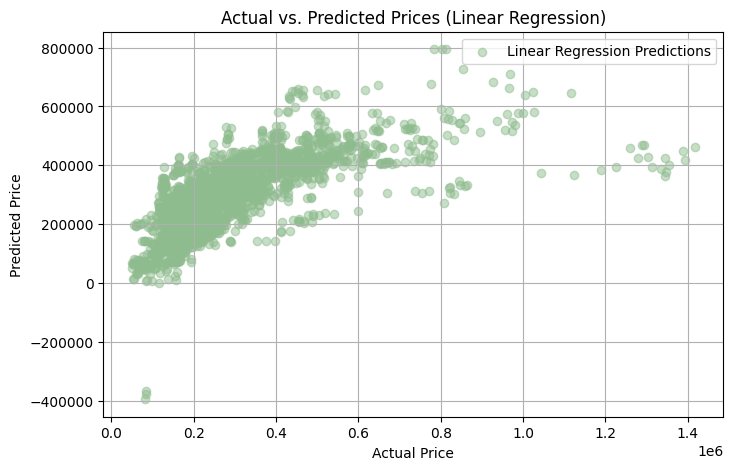

In [18]:

# ----- linear regression model -----
# training
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# prediction
lr_prediction_Y = lr_model.predict(X_test)

# evaluation
lr_metrics = {
    "Model": "Linear Regression",
    "MAE": mean_absolute_error(Y_test, lr_prediction_Y),
    "MSE": mean_squared_error(Y_test, lr_prediction_Y),
    "R² Score": r2_score(Y_test, lr_prediction_Y)
}
print(lr_metrics)

# save predictions
df_lr_predictions = pd.DataFrame({
    "Actual Price": Y_test.values,
    "Predicted Price (Linear Regression)": lr_prediction_Y
})
df_lr_predictions.to_csv("predicted_prices_lr.csv", index=False)
print("Linear Regression Predictions saved to predicted_prices_lr.csv")

# visualisation 
plt.figure(figsize=(8, 5))
plt.scatter(df_lr_predictions["Actual Price"], df_lr_predictions["Predicted Price (Linear Regression)"], 
            alpha=0.5, color="darkseagreen", label="Linear Regression Predictions")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()




### Random Forest

{'Model': 'Random Forest Regression', 'MAE': 10070.37700910009, 'MSE': 646947595.4627085, 'R² Score': 0.9813873612211406}


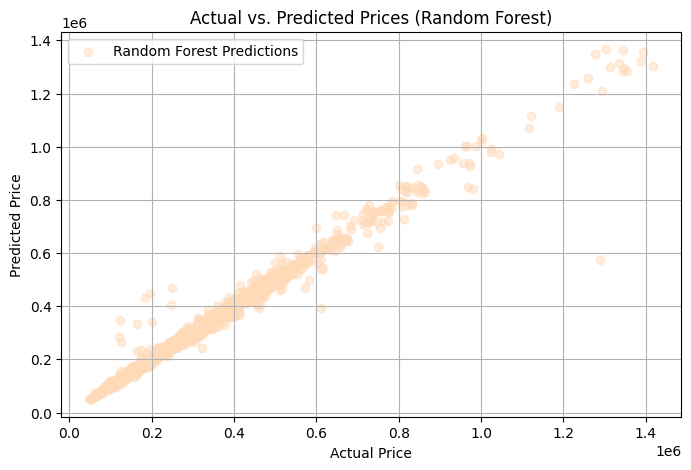

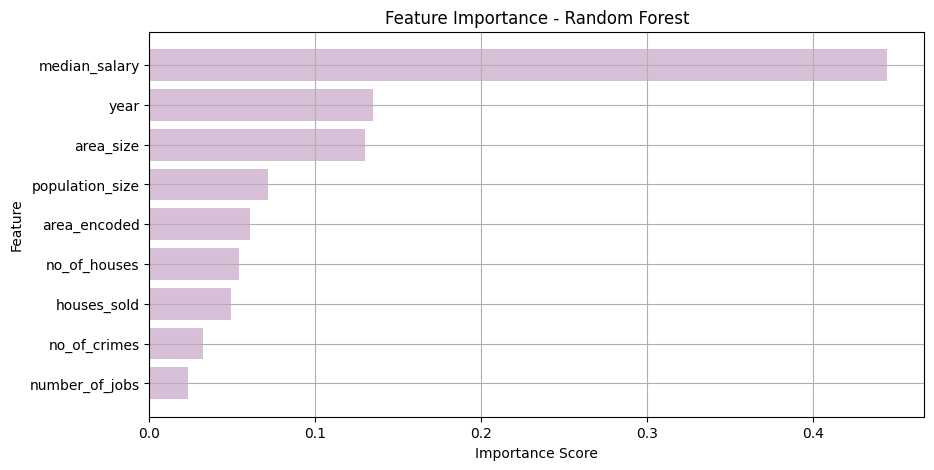

In [21]:
# ----- random forest model -----
# training 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# prediction
rf_prediction_Y = rf_model.predict(X_test)

# evaluation 
rf_metrics = {
    "Model": "Random Forest Regression",
    "MAE": mean_absolute_error(Y_test, rf_prediction_Y),
    "MSE": mean_squared_error(Y_test, rf_prediction_Y),
    "R² Score": r2_score(Y_test, rf_prediction_Y)
}
print(rf_metrics)

# save predictions
df_rf_predictions = pd.DataFrame({
    "Actual Price": Y_test.values,
    "Predicted Price (Random Forest)": rf_prediction_Y
})

df_rf_predictions.to_csv("predicted_prices_rf.csv", index=False)

# visualisation
plt.figure(figsize=(8, 5))
plt.scatter(df_rf_predictions["Actual Price"], df_rf_predictions["Predicted Price (Random Forest)"], 
            alpha=0.5, color="peachpuff", label="Random Forest Predictions")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color="thistle")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


